100%|██████████| 170M/170M [00:01<00:00, 98.0MB/s]



Training the CNN...
Epoch 1, Loss: 1.4528
Epoch 2, Loss: 1.0976
Epoch 3, Loss: 0.9418
Epoch 4, Loss: 0.8474
Epoch 5, Loss: 0.7710
Epoch 6, Loss: 0.7009
Epoch 7, Loss: 0.6349
Epoch 8, Loss: 0.5794
Epoch 9, Loss: 0.5253
Epoch 10, Loss: 0.4736

✅ Accuracy on test data: 70.11%

🔍 Visualizing filters from the first convolutional layer:


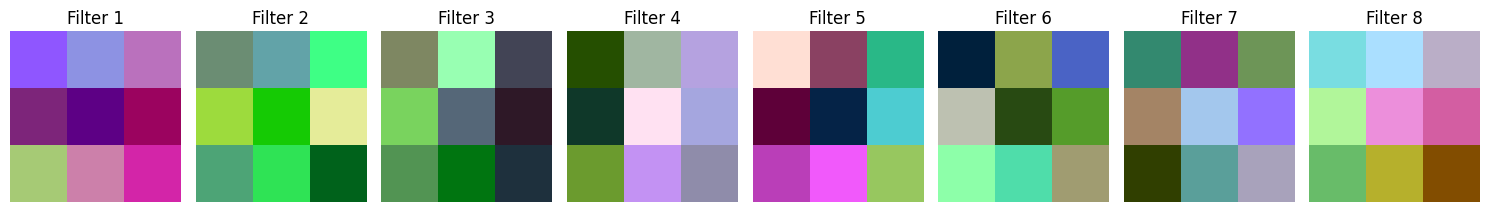

In [1]:
# Step 1: Load and Preprocess CIFAR-10 Dataset
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Data transformations: convert to tensor & normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training and test data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes  # Class names

# Step 2: Define CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # Output: 16 x 32 x 32
        self.pool = nn.MaxPool2d(2, 2)               # Output: 16 x 16 x 16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # Output: 32 x 16 x 16 → pool → 32 x 8 x 8
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Train the CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nTraining the CNN...")
for epoch in range(10):
    running_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Step 4: Evaluate Model Performance
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n✅ Accuracy on test data: {100 * correct / total:.2f}%")

# Step 5: Visualize Learned Filters from First Convolution Layer
def visualize_filters(layer, n_filters=8):
    filters = layer.weight.data.clone().cpu()
    fig, axs = plt.subplots(1, n_filters, figsize=(15, 4))
    for i in range(n_filters):
        f = filters[i]
        f = (f - f.min()) / (f.max() - f.min())  # Normalize for display
        axs[i].imshow(f.permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(f'Filter {i+1}')
    plt.tight_layout()
    plt.show()

print("\n🔍 Visualizing filters from the first convolutional layer:")
visualize_filters(model.conv1)
